# EDA

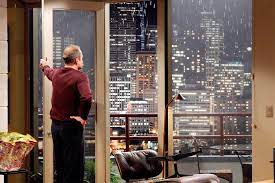

In [14]:
# Data processing packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from math import radians, cos, sin, asin, sqrt
import math

# Data Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats

# Interface packages
import psycopg2
import os
from dotenv import load_dotenv


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

In [15]:
# Import dataframe
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

cur = conn.cursor()
query_string = "select * from eda.king_county_house_details d inner join eda.king_county_house_sales s on s.house_id = d.id"
df = pd.read_sql(query_string, conn)
conn.close()

df.head(10)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,house_id,id
0,7129300520,3.000,1.000,1180.000,5650.000,1.000,NaN,0.000,3,7,1180.000,0.000,1955,0.000,98178,47.511,-122.257,1340.000,5650.000,2014-10-13,221900.000,7129300520,1
1,6414100192,3.000,2.250,2570.000,7242.000,2.000,0.000,0.000,3,7,2170.000,400.000,1951,19910.000,98125,47.721,-122.319,1690.000,7639.000,2014-12-09,538000.000,6414100192,2
2,5631500400,2.000,1.000,770.000,10000.000,1.000,0.000,0.000,3,6,770.000,0.000,1933,NaN,98028,47.738,-122.233,2720.000,8062.000,2015-02-25,180000.000,5631500400,3
3,2487200875,4.000,3.000,1960.000,5000.000,1.000,0.000,0.000,5,7,1050.000,910.000,1965,0.000,98136,47.521,-122.393,1360.000,5000.000,2014-12-09,604000.000,2487200875,4
4,1954400510,3.000,2.000,1680.000,8080.000,1.000,0.000,0.000,3,8,1680.000,0.000,1987,0.000,98074,47.617,-122.045,1800.000,7503.000,2015-02-18,510000.000,1954400510,5
5,7237550310,4.000,4.500,5420.000,101930.000,1.000,0.000,0.000,3,11,3890.000,1530.000,2001,0.000,98053,47.656,-122.005,4760.000,101930.000,2014-05-12,1230000.000,7237550310,6
6,1321400060,3.000,2.250,1715.000,6819.000,2.000,0.000,0.000,3,7,1715.000,NaN,1995,0.000,98003,47.310,-122.327,2238.000,6819.000,2014-06-27,257500.000,1321400060,7
7,2008000270,3.000,1.500,1060.000,9711.000,1.000,0.000,NaN,3,7,1060.000,0.000,1963,0.000,98198,47.410,-122.315,1650.000,9711.000,2015-01-15,291850.000,2008000270,8
8,2414600126,3.000,1.000,1780.000,7470.000,1.000,0.000,0.000,3,7,1050.000,730.000,1960,0.000,98146,47.512,-122.337,1780.000,8113.000,2015-04-15,229500.000,2414600126,9
9,3793500160,3.000,2.500,1890.000,6560.000,2.000,0.000,0.000,3,7,1890.000,0.000,2003,0.000,98038,47.368,-122.031,2390.000,7570.000,2015-03-12,323000.000,3793500160,10


In [16]:
# remove 
df = df.rename({'id':'house_id'},axis=1)
df = df.loc[:,~df.columns.duplicated()]

# checking for missing values
df.isna().sum()

# investigating what values might be missing in the waterfront column
df.waterfront.value_counts()
# reasonable assumption for now: if NaN then the house isn't at the water front.
df.waterfront = df.waterfront.fillna(0)

# investigating what values might be missing in the view column
df.view.value_counts()
# reasonable assumption for now: if NaN then the house hasn't been viewed yet
df.view = df.view.fillna(0)

# investigating what values might be missing in the sqft_basement column.
(df.sqft_living == df.sqft_above + df.sqft_basement).value_counts()
(df.sqft_basement.isna().sum())
df.sqft_basement = df.sqft_living - df.sqft_above
# filling missing values as difference of living and above


# investigating what values might be missing in yr_renovated and whether there are any values with less than 5 digits that need manual adjustment
df.yr_renovated.value_counts().sort_values()
# all values are either NaN, 0 or => 19480. Assuming that NaN, just as 0, means it never got renovated. Filling with 0
df.yr_renovated = df.yr_renovated.fillna(0)

# adjust sqft sizes to sqrm to reject imperialism and make data understandable for my european customer. might be rounding this later
sqft = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

df[sqft] = df[sqft].apply(lambda x: round(x * 0.092903,1))
df.columns = df.columns.str.replace('sqft','sqm')

In [17]:
# fixing column values and datatypes
# bedrooms = int, waterfront = bool, view = int
df.bedrooms = df.bedrooms.astype('int')
df.waterfront = df.waterfront.astype('bool')
df.view = df.view.astype('int')

# fixing datetimes
df.yr_renovated = (df.yr_renovated / 10).replace(0, np.nan)
df.yr_renovated = pd.to_datetime(df.yr_renovated, format='%Y')
df.yr_built = pd.to_datetime(df.yr_built, format='%Y', errors='coerce')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

# Get the position of the aproximate position of the Central City and measuring the distance of all other coordinates from there (in km):
CENTER = [47.6102, -122.337]

def get_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

df['distance_from_center'] = df.apply(lambda row: get_distance(CENTER[0],CENTER[1], row['lat'], row['long']), axis=1)

# creating a new variable for price_per_sqm since data suggests that these strongly correlate
df['price_per_sqm'] = df['price'] / df['sqm_living']

# renaming and reindexing some columns for better readability
df = df.reindex(columns=['house_id', 'bedrooms', 'bathrooms', 'floors', 'sqm_living', 'sqm_above', 'sqm_basement', 'sqm_lot', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long','distance_from_center', 'sqm_living15', 'sqm_lot15', 'date', 'price', 'price_per_sqm'])

df.head()

,house_id,bedrooms,bathrooms,floors,sqm_living,sqm_above,sqm_basement,sqm_lot,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,distance_from_center,sqm_living15,sqm_lot15,date,price,price_per_sqm
0,7129300520,3,1.000,1.000,109.600,109.600,0.000,524.900,False,0,3,7,1955-01-01,NaT,98178,47.511,-122.257,12.539,124.500,524.900,2014-10-13,221900.000,2024.635
1,6414100192,3,2.250,2.000,238.800,201.600,37.200,672.800,False,0,3,7,1951-01-01,1991-01-01,98125,47.721,-122.319,12.394,157.000,709.700,2014-12-09,538000.000,2252.931
2,5631500400,2,1.000,1.000,71.500,71.500,0.000,929.000,False,0,3,6,1933-01-01,NaT,98028,47.738,-122.233,16.195,252.700,749.000,2015-02-25,180000.000,2517.483
3,2487200875,4,3.000,1.000,182.100,97.500,84.500,464.500,False,0,5,7,1965-01-01,NaT,98136,47.521,-122.393,10.792,126.300,464.500,2014-12-09,604000.000,3316.859
4,1954400510,3,2.000,1.000,156.100,156.100,0.000,750.700,False,0,3,8,1987-01-01,NaT,98074,47.617,-122.045,21.901,167.200,697.100,2015-02-18,510000.000,3267.136


In [18]:
# Exploring the map-data
df_map = df[['lat','long','zipcode','price','price_per_sqm','distance_from_center','grade']].copy()
# df_map['zipcode'] = df.zipcode.astype('category')

# df_map = df_map[~df_map['zipcode'].isin([98126, 98106, 98116, 98103, 98107, 98105, 98115, 98117, 98136])]
df_map = df_map.query('distance_from_center <= distance_from_center.quantile(0.1) or distance_from_center >= distance_from_center.quantile(0.95)')

# limit dataframe to the Central City Houses and repeat analysis
df = df.query('distance_from_center <= distance_from_center.quantile(0.1)')




Amy Williams, Seller: Italian mafiosi, sells several central houses(top10%) over time, needs average outskirt houses over time to hide from the FBI

Questions to ask:
- What Houses are in the central, what are in the outskirts (map all houses and cluster them by zipcode as a start)
- what are top 10% houses? condition, grade, renovated? neighborhood equally big houses. price
- what are medium houses: all values in median?
- correlation between condition/grade and renovated? if not renovated then since built.
- interesting: houses with basements to hide bodies
- avoid good houses in bad neighborhoods and bad houses in good neighborhoods to avoid attention
- selling date shouldnt really matter
- check skewness (with qq plot?) of sqm_living, sqm_lot, yr_built, price, bedrooms/bathroom ratio
- regression analysis with price = yr_built, yr_renovated, sqm_living, condition, grade
- zipcodes into categories -> dummies to check against for good or bad region
- when to buy and when to sell

In [19]:
accesstoken = os.getenv('MAPBOX_ACCESS_TOKEN')


# normalize the dotsize with ln() becaue the price is on an exponential scale
def normalize_size(data, max_size=20):
    norm_size = np.log(data + 1)
    norm_size = (norm_size - np.min(norm_size)) / (np.max(norm_size) - np.min(norm_size))
    norm_size = norm_size * max_size
    return norm_size

norm_size = normalize_size(df_map.price)

# New Figure for the map
fig = go.Figure()

# Figure for the map plotting all houses left in df_map
fig.add_trace(go.Scattermapbox(
        lat=df_map.lat,
        lon=df_map.long,
        mode='markers',
        marker=dict(
            size=norm_size,
            color=df_map.grade,
            colorscale='Aggrnyl'
        ),
        text=df_map.zipcode
    )
)

# Adding the Space Needle as reference point for the city center
fig.add_trace(go.Scattermapbox(
        lat=[CENTER[0]],
        lon=[CENTER[1]],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color='red',
            symbol='star'
        ),
        text=['Central Business District'],
        name='Point of Interest'
))

# making everything look a little more pretty
fig.update_layout(
    mapbox_style='dark',
    mapbox=dict(
        accesstoken=accesstoken,
        center=dict(lat=CENTER[0], lon=CENTER[1]),
        zoom=10
    ),
    margin={'r':0,'t':0,'l':0,'b':0},
    title_text='Seattle',
    title_font_color='black',
    coloraxis_showscale=False,
    autosize=True,
    width=1600,
    height=1200,
    font_family='Gravitas One',
    showlegend=False
)

fig.show()

In [20]:
# house_id	bedrooms	bathrooms	floors	sqm_living	sqm_above	sqm_basement	sqm_lot	waterfront	view	condition	grade	yr_built	yr_renovated	zipcode	lat	long	sqm_living15	sqm_lot15	date	price
def get_coords(rows, columns):
    coords_list = [[row, col] for row in range(1, rows+1) for col in range(1, columns+1)]
    return coords_list

def histogram_this(lst,pos):
    for i in range(len(lst)):
        fig.add_trace(go.Histogram(
                        x=df[lst[i]],
                        name=f'{lst[i]}'),
                        pos[i][0],pos[i][1]                        
                        )
        
figrows, figcols = 5,2
subplot_lst = ['price','sqm_living','condition','grade','yr_built','yr_renovated','date','price_per_sqm']
subplot_pos = get_coords(figrows,figcols)

fig = make_subplots(rows=figrows, cols=figcols)
histogram_this(subplot_lst,subplot_pos)
fig.update_layout(
    plot_bgcolor='#292929',
    paper_bgcolor='#1F1F1F',
    font_color='#A8A8A8',
    height=800)
fig.update_traces(marker_line_color='#1F1F1F',
                  marker_line_width=0.2, opacity=0.7,
                  )
fig.update_xaxes(showline=False, zerolinecolor='#1F1F1F', linecolor='#3D3D3D')
fig.update_yaxes(zerolinecolor='#3D3D3D', linecolor='#3D3D3D', gridcolor='#3D3D3D')
fig.show()

Some findings are:
- Strong linear relationship between price and size of the real estate. chi² distributed which means its mostly normally distributed but with a heavy tail to the right
- price's skewness is a lot less when measured in price_per_sqm and the outliers are also party taken care of
- Condition is very left skewed. Except for some very few objects with 1 and 2, the lowest but also median condition is 3.
- Grade is a Scale from 1 to 13, normally distributed around the ~center.
- there is some evidence that houses are rather being sold in the warmer weeks of the year. however, that mustn't necessarily reflect on the price and therefore profit
- counting values in distance_from_center is pointless as the city center isn't central to all the houses in the data.
- of the houses that were renovated, most were renovated in recent years. But the sub-dataset is so small, that it's not representative for the whole data.
- dataset is from may 2014 to may 2015

Some Regression Analysis:
- The following section will have a brief regression analysis to test some of the hypothesis. Variables that weren't significant or provided no fit to the model have been dropped. Those include:
    - yr_renovated delivers no explanation for the whole dataset but has also almost no instances. therefore dropping and might need another analysis
    - Having a basement at best introduces spurious correlation. It appears that a basement has a negative impact on the price when this is only because houses in the center are more expensive but those tend to have no basement.

- Condition has absolutely no impact on the price in the central city

- As we limit our findings to the city center, all the variables that could previously explain the price of a house and particularly its price per square meter have lost most of their explanatory power. Conclusion: mostly speculation objects?
- Even the objects size itself provides significantly less fit for the price explanation
- the time of the year plays no role anymore
- grade and age are the best estimators for prices: find a highly graded young house with a low price

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     1044.
Date:                Sun, 02 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:12:36   Log-Likelihood:                -30162.
No. Observations:                2160   AIC:                         6.033e+04
Df Residuals:                    2156   BIC:                         6.035e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.421e+06   2.95e+05     18.380      0.0

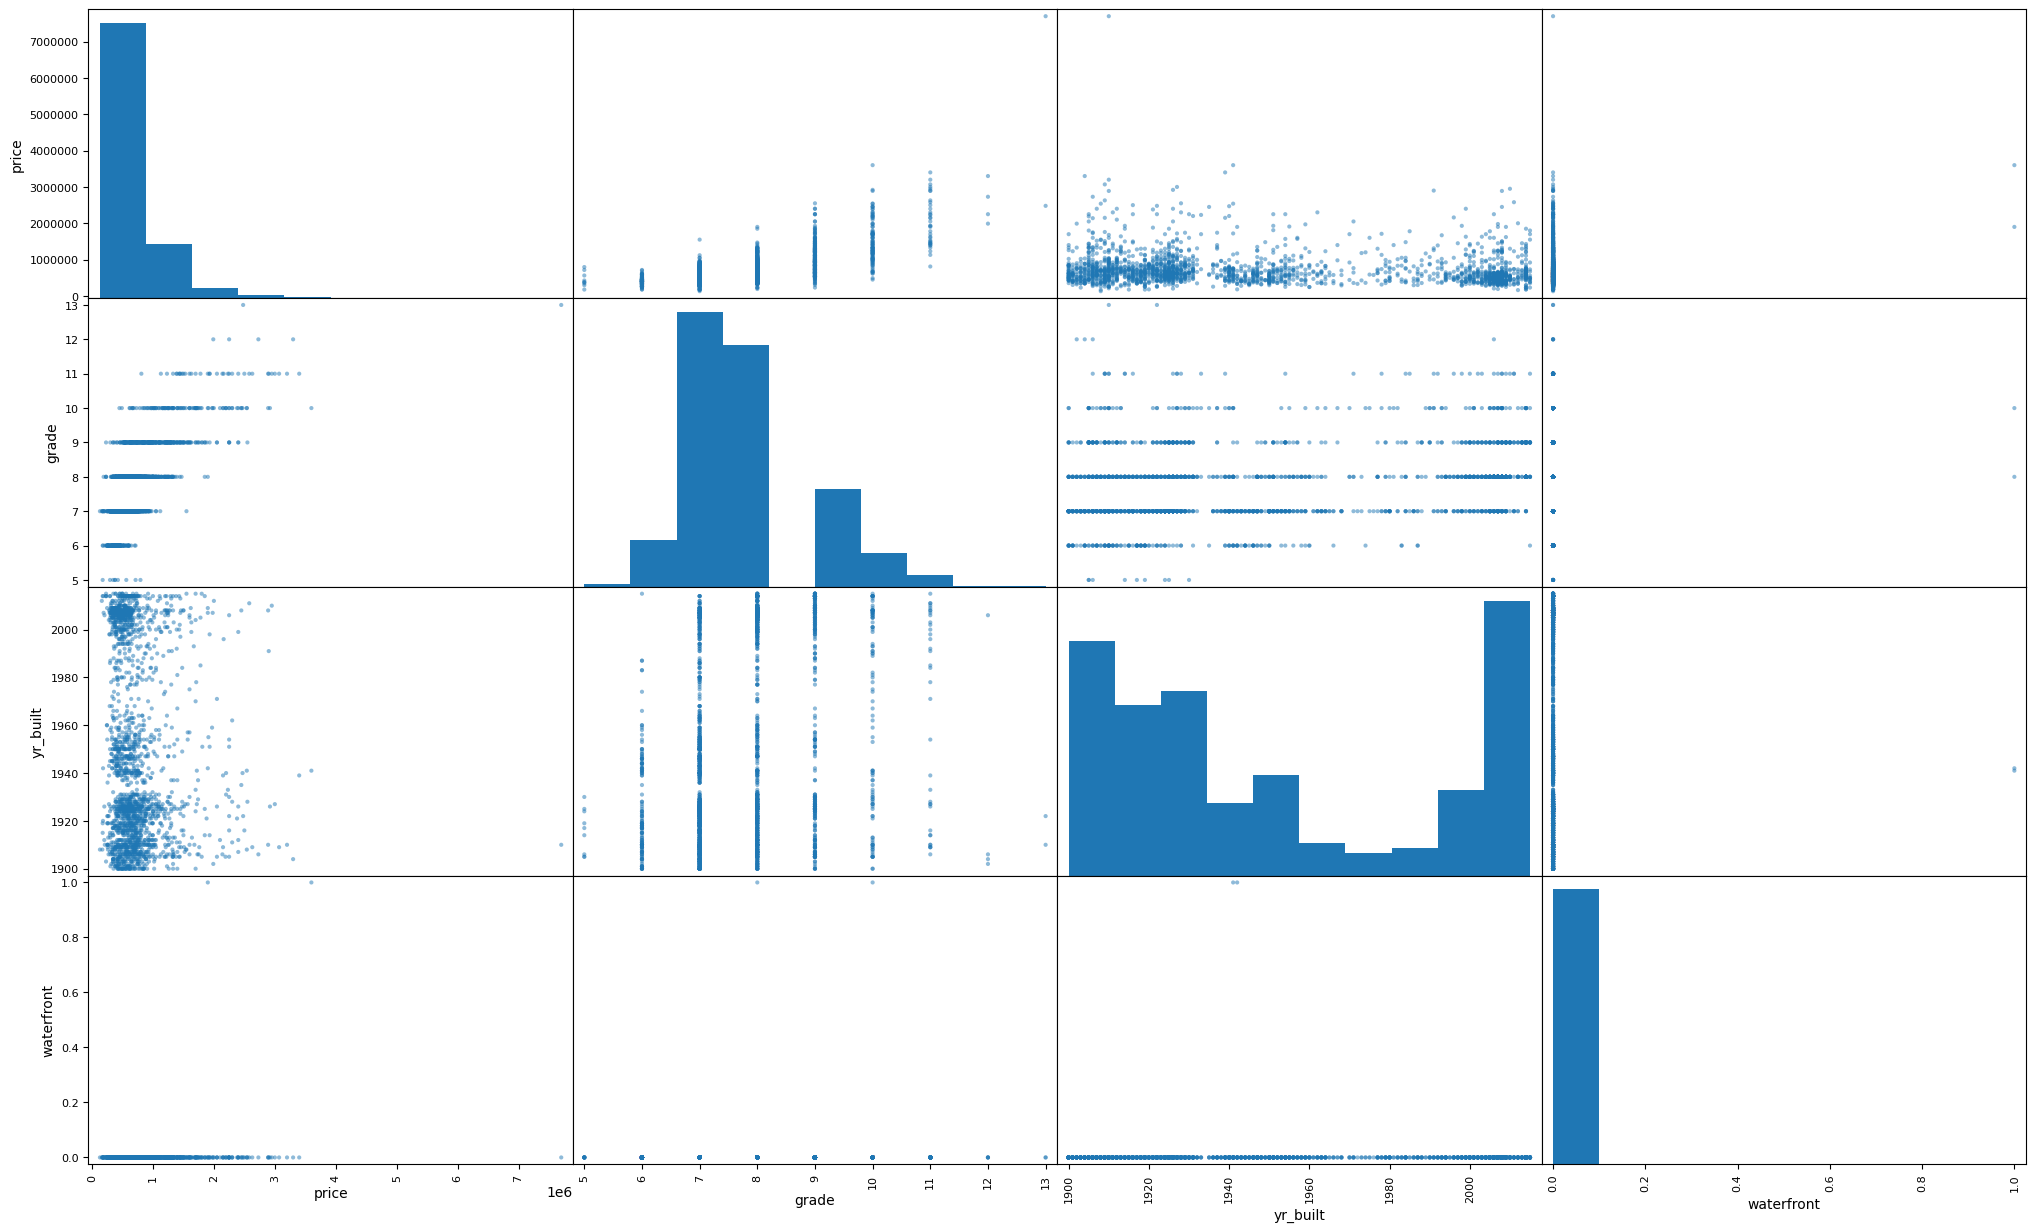

In [21]:
df_reg = df.copy()
df_reg['yr_built'] = df_reg['yr_built'].dt.year
df_reg['yr_renovated'] = df_reg['yr_renovated'].dt.year
df_reg['date_yr'] = df_reg['date'].dt.year
df_reg['date_month'] = df_reg['date'].dt.month
df_reg['waterfront'] = df_reg['waterfront'].astype(int)
df_reg['basement_dummy'] = np.where(df['sqm_basement'] != 0, 1, 0)
df_reg['yr_renovated'] = df_reg['yr_renovated'].fillna(0).astype(int)
df_reg['renovation_dummy'] = (df_reg['yr_renovated'] != 0).astype(int)
reg_list = ['price','grade','yr_built','waterfront']


Y = df_reg[reg_list[0]]
X = df_reg[reg_list[1:]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
pd.plotting.scatter_matrix(df_reg[reg_list],figsize=(25,15))
print(model.summary())



yr_built = only says that houses far from the center are newer. newer houses are a little bit more likely to have a high grade
we know that the month and year of selling has no impact on the price. dripping from OLS
a basement reduces the price of the house: spurous correlation? maybe basements are only in poor areas
basement_dummy and doesnt increase the fit of the model, therefore dropping
waterfront increases the price but has no positive impact on the houses' ratings


In [22]:
# ['price','sqm_living','condition','grade','yr_built','distance_from_center','waterfront']
Y = df_reg['grade']
X = df_reg[['price','sqm_living','condition','yr_built','renovation_dummy','distance_from_center','date_month']]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     547.6
Date:                Sun, 02 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:12:36   Log-Likelihood:                -2121.3
No. Observations:                2160   AIC:                             4259.
Df Residuals:                    2152   BIC:                             4304.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -13.6353 

The price of the house provides the best explanation (fit) for the grade, while size (and price_per_sqm) are significant, they provide almost no fit to the model.
That means the grading of a house is best described by its price, regardless of the houses size or its condition

In [23]:
# create a variable that calculates the profit margin in % for each month

df_monthly = df_reg.groupby(['date_month']).mean().reset_index()
df_monthly['monthly_margin'] = (df_monthly.price_per_sqm / df_monthly.price_per_sqm.mean() -1 ) * 100

# get average price per squaremeter per year and create a variable that measures by how much % the average price per square meter changes depending on when the house was built

yearly_average_ppsqm = df.groupby('yr_built')['price_per_sqm'].mean().reset_index()
df = pd.merge(df, yearly_average_ppsqm, on='yr_built', suffixes=('', '_avg'))
df['ppsqm_variation'] = (df.price_per_sqm_avg / df.price_per_sqm.mean() -1) * 100

df

,house_id,bedrooms,bathrooms,floors,sqm_living,sqm_above,sqm_basement,sqm_lot,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,distance_from_center,sqm_living15,sqm_lot15,date,price,price_per_sqm,price_per_sqm_avg,ppsqm_variation
0,9297300055,4,3.000,2.000,274.100,183.900,90.100,464.500,False,3,3,9,1979-01-01,NaT,98126,47.571,-122.375,5.171,198.800,371.600,2015-01-24,650000.000,2371.397,3498.801,-12.713
1,1189001180,3,2.250,1.000,154.200,103.100,51.100,557.400,False,0,3,7,1979-01-01,NaT,98122,47.611,-122.297,3.001,133.800,379.000,2014-06-03,425000.000,2756.161,3498.801,-12.713
2,2771104965,2,1.750,1.500,190.500,190.500,0.000,371.600,False,2,3,8,1979-01-01,NaT,98119,47.642,-122.373,4.404,180.200,371.600,2015-01-30,825000.000,4330.709,3498.801,-12.713
3,1186000095,4,2.750,3.000,214.600,214.600,0.000,373.500,False,0,5,8,1979-01-01,NaT,98122,47.615,-122.291,3.496,210.900,348.400,2014-07-08,890000.000,4147.251,3498.801,-12.713
4,9829200580,3,2.750,2.000,232.300,220.200,12.100,589.900,False,0,5,9,1979-01-01,NaT,98122,47.603,-122.285,3.969,194.200,506.700,2014-09-17,990000.000,4261.731,3498.801,-12.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,9521100031,3,3.250,3.000,143.100,143.100,0.000,132.700,False,0,3,9,2013-01-01,NaT,98103,47.665,-122.353,6.188,154.200,306.600,2014-06-18,690000.000,4821.803,4386.550,9.434
2156,952001495,4,1.750,1.000,201.600,127.300,74.300,534.200,False,2,3,7,1975-01-01,NaT,98116,47.567,-122.383,5.932,134.700,534.200,2015-03-06,588000.000,2916.667,4174.802,4.152
2157,1130000005,3,2.250,2.000,294.500,207.200,87.300,464.500,False,0,5,10,1975-01-01,NaT,98102,47.635,-122.318,3.094,294.500,501.700,2014-07-15,1600000.000,5432.937,4174.802,4.152
2158,3083000048,5,2.750,1.000,206.200,114.300,92.000,371.600,False,0,3,7,1973-01-01,NaT,98144,47.575,-122.305,4.553,146.800,371.600,2014-05-30,427000.000,2070.805,4979.253,24.221


In [28]:
yearly_average_ppsqm

,yr_built,price_per_sqm
0,1900-01-01,4197.047
1,1901-01-01,3355.304
2,1902-01-01,4005.240
3,1903-01-01,4184.637
4,1904-01-01,4315.677
...,...,...
109,2011-01-01,4352.586
110,2012-01-01,3770.347
111,2013-01-01,4386.550
112,2014-01-01,3922.228


Creating Some plots to visualize the previous findings

The price of a house can at best be predicted by the grade it's been assigned and the year it was built

In [24]:
# plots for 
#   - price per squaremeter for each year a house was built
#   - price achievable on average per grade

# create a variable that measures by how much % the average price per squaremeter changes depending on when the house was built

fig_grade = px.bar(df.groupby(['grade']).mean().reset_index(),
             x='grade',
             y='price')

fig_year = px.line(df.groupby('yr_built').mean().reset_index().sort_values('yr_built'),
                 x='yr_built',
                 y='ppsqm_variation')

# The time of the year is relevant for profit.
# PROBLEM: looks like it makes sense but it doesnt. The findings are highly insignificant with p = 0.7

fig_month = px.bar(df_monthly,
             x='date_month',
             y='monthly_margin')



fig = make_subplots(rows=3, cols=1)
fig.add_trace(fig_grade.data[0],1,1)
fig.add_trace(fig_year.data[0],2,1)
fig.add_trace(fig_month.data[0],3,1)
fig.update_layout(
    plot_bgcolor='#292929',
    paper_bgcolor='#1F1F1F',
    font_color='#A8A8A8',
    height=1200)
fig.update_traces(marker_line_color='#1F1F1F',
                  marker_line_width=0.2, opacity=0.7,
                  )
fig.update_xaxes(showline=False, zerolinecolor='#3D3D3D', linecolor='#3D3D3D', gridcolor='#3D3D3D')
fig.update_yaxes(showline=True, zerolinecolor='#FFFFFF', linecolor='#3D3D3D', gridcolor='#3D3D3D')

fig.show()

In [25]:
# Find a suitable houses for investment in the central city meeting the conditions:
#   - has a high grade as we know you can achieve a better market price the higher the grade is
#   - look for a relatively old house as we know that older houses can achieve a higher price per square-meter living space
#   - find out whether there are any underpriced houses on the market

df_best_center = df.query('grade > grade.quantile(0.9) and yr_built < yr_built.quantile(0.1) and ppsqm_variation < 0')

fig = go.Figure()

# Figure for the map plotting all houses left in df_best_center
fig.add_trace(go.Scattermapbox(
        lat=df_best_center.lat,
        lon=df_best_center.long,
        mode='markers',
        marker=dict(
            size=norm_size,
            color=df_best_center.grade,
            colorscale='Aggrnyl'
        ),
        text=df_best_center.zipcode
    )
)

# Adding the Space Needle as reference point for the city center
fig.add_trace(go.Scattermapbox(
        lat=[CENTER[0]],
        lon=[CENTER[1]],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color='red',
            symbol='star'
        ),
        text=['Central Business District'],
        name='Point of Interest'
))

# making everything look a little more pretty
fig.update_layout(
    mapbox_style='dark',
    mapbox=dict(
        accesstoken=accesstoken,
        center=dict(lat=CENTER[0], lon=CENTER[1]),
        zoom=10
    ),
    margin={'r':0,'t':0,'l':0,'b':0},
    title_text='Seattle',
    title_font_color='black',
    coloraxis_showscale=False,
    autosize=True,
    width=1600,
    height=1200,
    font_family='Gravitas One',
    showlegend=False
)

fig.show()
df_best_center.head()

,house_id,bedrooms,bathrooms,floors,sqm_living,sqm_above,sqm_basement,sqm_lot,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,distance_from_center,sqm_living15,sqm_lot15,date,price,price_per_sqm,price_per_sqm_avg,ppsqm_variation
934,1346300035,5,3.000,2.500,416.200,317.700,98.500,464.500,False,0,5,12,1902-01-01,NaT,98112,47.627,-122.315,2.534,299.100,520.300,2014-06-26,1990000.000,4781.355,4005.240,-0.078
